In [7]:
# import dill
import numpy as np
from matplotlib import figure, gridspec,colors
# from pathlib import Path
# from astropy.table import Table
# from astropy import units as u
# from astropy.coordinates import SkyCoord

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization as vis



bands = ["u_5_15", "u_15_25", "u_25_35", "u_35_45", "u_45_55", "u_55_65", "u_65_75", "u_75_90", "l_15_5", "l_25_15", "l_35_25", "l_45_35", "l_55_45", "l_65_55", "l_75_65", "l_90_75", "center"]
versions = ["hess1","hess1u"]
paths = [f"/lustre/fs22/group/hess/user/wybouwt/full_scanner_survey/{version}/{band}" for band in bands for version in versions]
# mplets = scani.Multiplets(paths[0])
# mplets.appendMultiplets(*[scani.Multiplets(path) for path in paths[1:]])
mplet_list = [scani.Multiplets(path) for path in paths]


unicorns = [9,18]
for j in unicorns:
    mplet_list[j].objectifyColumns()

    
mplets = mplet_list[0]
mplets.appendMultiplets(*mplet_list[1:])

Try to get the weird log xscale plot

In [ ]:
vis.hist(np.log10(mplets.table["dt"]),bins="freedman",histtype="step")

Aitov scatter

In [ ]:
fig,ax = mplets.getAitoffFigure()
fig.savefig("figures/combined/aitoff.png",facecolor="white",dpi=300)

Cornerplot of the resulting multiplets

In [ ]:
# plotting mplet results
from corner import corner

fig = corner(mplets.table.to_pandas(),var_names=["Nmax","dt","da"])
# fig.savefig("figures/combined/corner_center.png",facecolor="white",dpi=300)

TeVCat search and distance histogram

In [8]:
from tevcat import TeVCat
tevcat = TeVCat()
mplets.searchTeVCat(tevcat.sources)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2


Unknown observatory name found in GRB 160821B:  None
Unknown "discoverer" ID found in GRB 160821B: None
Unknown observatory name found in SNR G004.8+6.2:  None
Unknown "discoverer" ID found in SNR G004.8+6.2: None
Unknown observatory name found in 3HWC J0621+382:  None
Unknown "discoverer" ID found in 3HWC J0621+382: None
Unknown observatory name found in 3HWC J0630+186:  None
Unknown "discoverer" ID found in 3HWC J0630+186: None
Unknown observatory name found in 3HWC J0631+107:  None
Unknown "discoverer" ID found in 3HWC J0631+107: None


In [ ]:
current_mask = nosource_mask

vline_sourcebound = .2
hist = vis.hist(mplets.table[current_mask]["TEVCAT_DISTANCES_DEG"],bins="freedman",histtype="step",stacked=True)
ax = plt.gca()
ax.set_xlabel("Distance to nearest TeVCat source [deg]")
ax.set_ylabel("Counts")
ylim = ax.get_ylim()
ax.vlines(vline_sourcebound,0,ylim[1],color="red",ls="--",label=f"{vline_sourcebound} deg")
ax.set_ylim(*ylim)
# ax.set_yscale("log")
ax.set_xlim(0,15)
ax.legend()
# ax.set_xscale("log")
# plt.savefig("figures/combined/sourcedist_hist.png",facecolor="white")

HEALPix

1.8322594196359496


/lustre/fs22/group/hess/user/wybouwt/conda/gammatransients/lib/python3.9/site-packages/healpy/visufunc.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/lustre/fs22/group/hess/user/wybouwt/conda/gammatransients/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


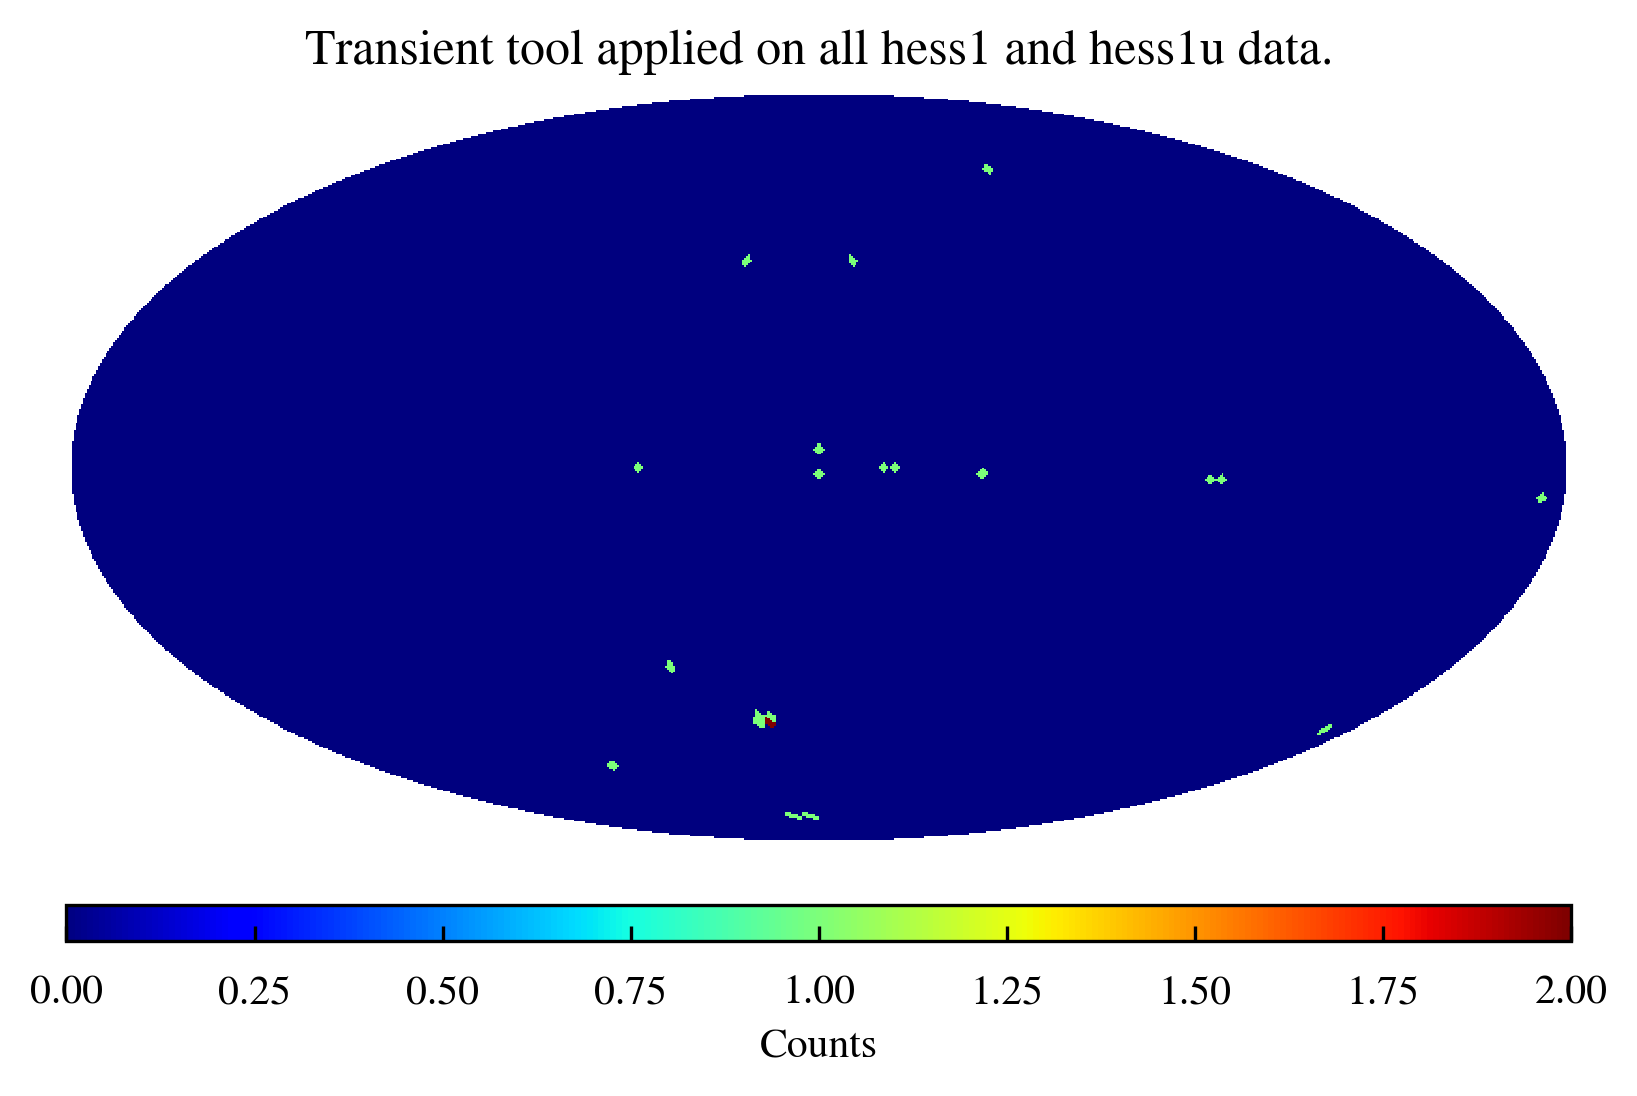

In [48]:
fig = plt.figure(dpi=300)

Nmax_mask = mplets.table["Nmax"] >= 4
dt_mask = mplets.table["dt"] <= 1e9
current_mask = nosource_mask*Nmax_mask*dt_mask

cmap = cm.jet
cmap.set_bad("r")
NSIDE = 2**5
m = scani.cat2hpx(mplets.table[current_mask]["MEDIAN_RA"],mplets.table[current_mask]["MEDIAN_DEC"],nside=NSIDE)
print(np.sqrt(hp.nside2pixarea(NSIDE,degrees=True)))
mmin, mmax = min(m),max(m)

hp.mollview(m,cmap=cmap, hold=True,nest=False,min=mmin,max=mmax,notext=True,fig=1,cbar=False,title="Transient tool applied on all H.E.S.S. data.")
#create a colorbar axis
cax = fig.add_axes([0.125, 0.1, 0.775, 0.03])

#create a colorbar and normalise it
# cmap.set_under("white")
# axs = fig.get_axes()
# axs[0].images[0].set_norm(colors.SymLogNorm(100))
cb = mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=mmin,vmax=mmax),
                               orientation='horizontal')
cb.set_label("Counts")
cb.solids.set_edgecolor("face")

plt.show()
# plt.savefig("figures/combined/healpy.png",facecolor="white")

Nmax histogram

Nmax left after mask: 5


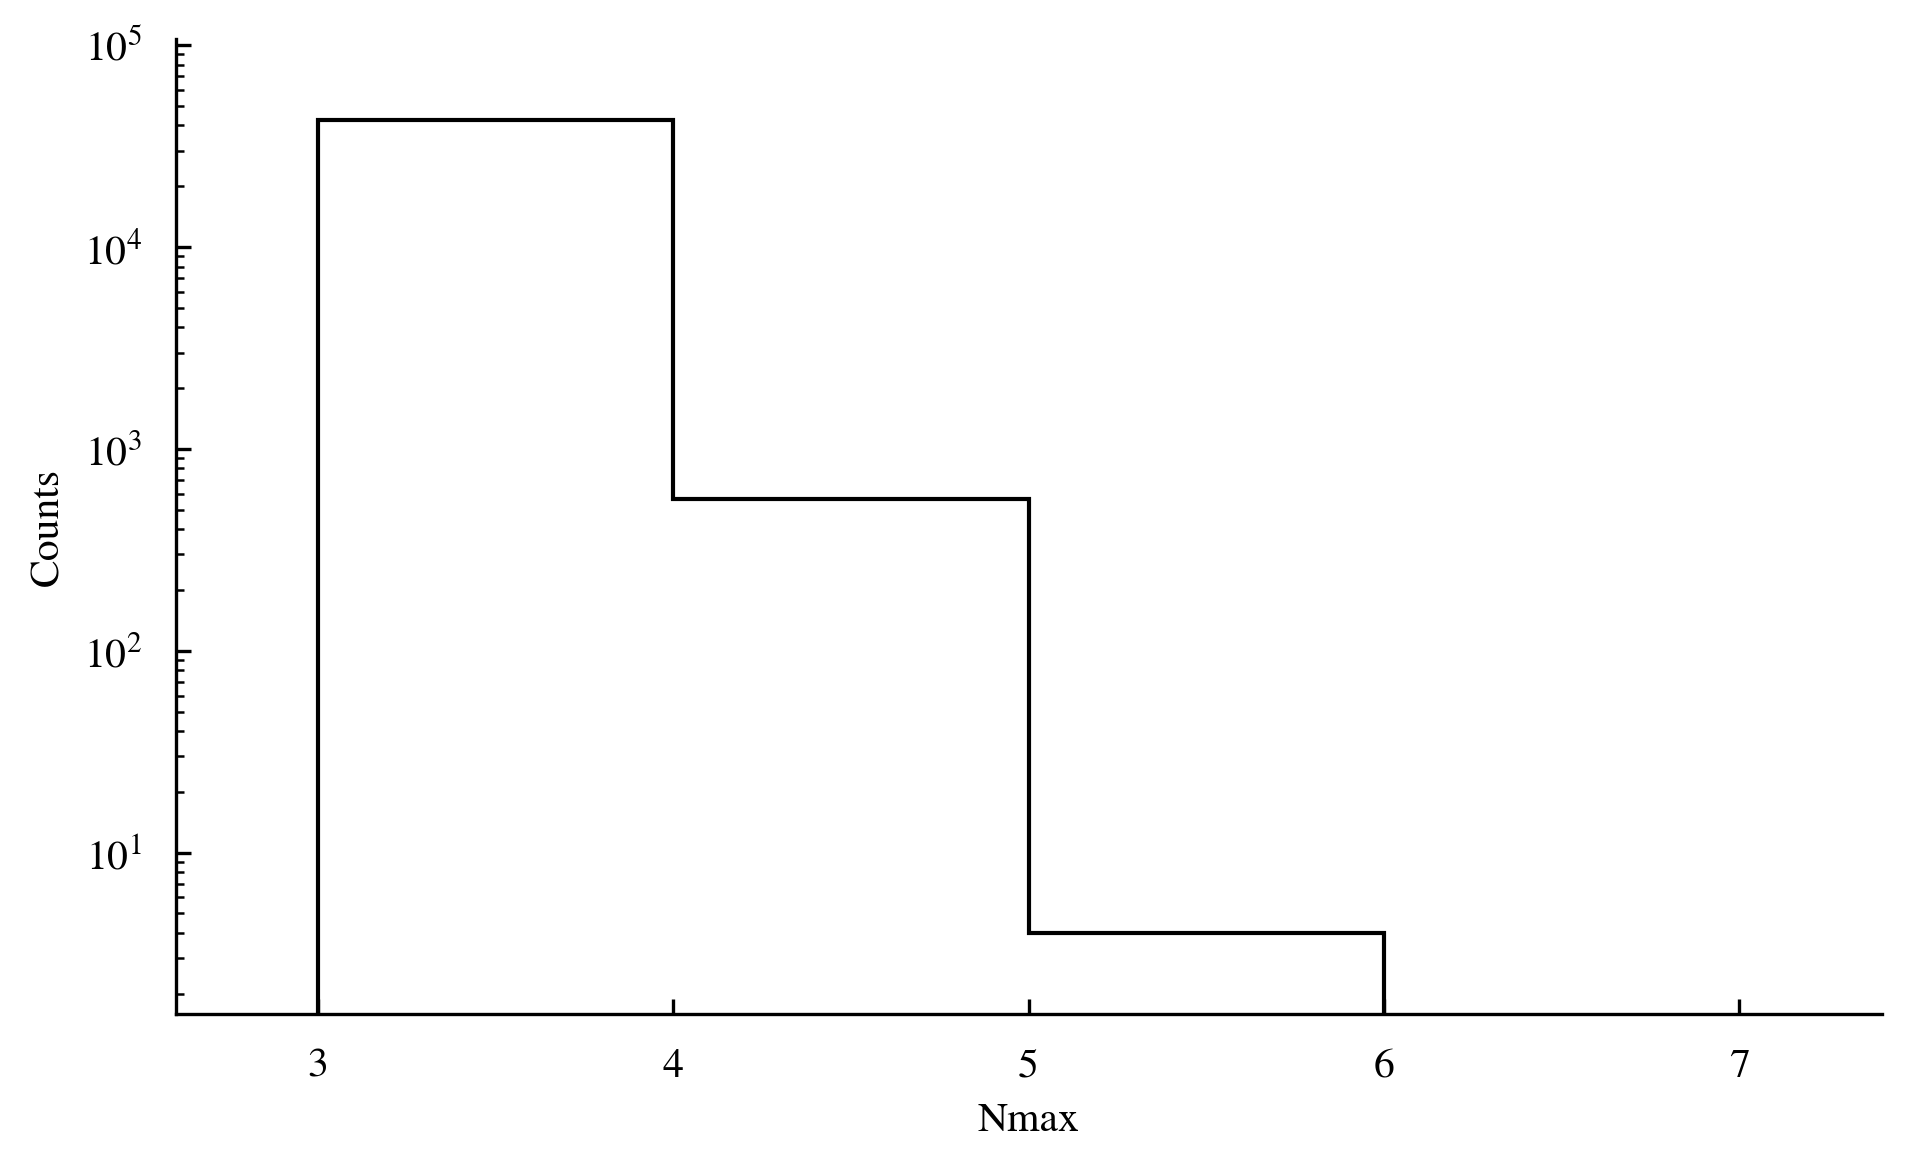

In [4]:
current_mask = nosource_mask

remaining_Nmax = max(mplets.table[current_mask]["Nmax"])
print(f"Nmax left after mask: {remaining_Nmax}")
hist = vis.hist(mplets.table[current_mask]["Nmax"],bins=range(3,remaining_Nmax+3),histtype="step")
ax = plt.gca()
ax.set_xlabel("Nmax")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# ax.set_xticks(range(3,22))
# plt.savefig("figures/combined/Nmax_hist.png",facecolor="white")

In [47]:
# current_mask = nosource_mask# * mplets.table["Nmax"] > 3
temp = mplets.table[current_mask]["Nmax","OBS_ID","dt","da","MEDIAN_GLAT","TEVCAT_SOURCE_NAME","TEVCAT_SOURCE_TYPE","TEVCAT_DISTANCES_DEG"]
temp[:]

Nmax,OBS_ID,dt,da,MEDIAN_GLAT,TEVCAT_SOURCE_NAME,TEVCAT_SOURCE_TYPE,TEVCAT_DISTANCES_DEG
int64,uint32,float64,float64,float64,str21,str22,float64
4,18875,707145472.0,0.12638969431230784,-6.143019420950838,Crab,PWN,0.386874154272836
4,131676,987639296.0,0.15651317799029035,0.41409916940319846,HESS J1702-420,UNID,0.7821793679869604
4,66203,831815168.0,0.19034808197279549,-51.91673570764927,PKS 2155-304,HBL,0.5056663331788517
4,34469,935258112.0,0.1764778855707523,-53.52180341557031,PKS 2155-304,HBL,1.8077304314759142
4,129285,661189376.0,0.19586450701453717,3.4566764153478244,SNR G000.9+00.1,PWN,3.797218392458671
4,22184,904125056.0,0.17096287322594822,-52.76015440460705,PKS 2155-304,HBL,0.6514274628135278
4,153116,972845056.0,0.18033274753230608,-0.8711692148888963,VER J1746-289,UNID,0.7964388930745058
4,134488,989905152.0,0.19156166091482038,-40.71132687974568,AE Aquarii,Cat. Var.,16.47873534361619
4,20274,859170176.0,0.19828383439128688,62.9107771967971,3C 279,FSRQ,8.752474218344432


In [ ]:
temp.sort["Nmax"]

In [56]:
Nmax = 3
run_count_rate = Nmax/(28*60)
expected_photons_3sec = 3*run_count_rate

expected_photons_3sec

0.005357142857142857

In [57]:
from math import factorial
sum = 1

for i in range(Nmax):
    sum -= expected_photons_3sec**(i)*np.exp(-expected_photons_3sec)/(factorial(i))
sum
                                                                      
                                                                    

2.5521355153265184e-08